In [75]:
from python_server_FCEUX import Server
import matplotlib.pyplot as plt
import json
import numpy as np
import cv2

In [76]:
server = Server()

Waiting connection from emulator...
Connected:  <socket.socket fd=1868, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 12345), raddr=('127.0.0.1', 54922)>


In [47]:
def jsonsMode(string):
    a = string.decode()
    return json.loads(a)

In [139]:
'''
Get pixeis image.
params: {(int) down_sample -> 1, (int) len_max_x -> 255, (int) len_max_y -> 239, (int) len_min_x -> 1,
(int) len_min_x -> 1, (bool) grayscale -> False}

'''
image = server.sendCommandAndReceiveOperation(json.dumps({'operation': 'getScreenShot',
          'params': {
              'grayscale': True,
              'down_sample': 2,
              'len_min_y': 45,
              'len_max_y': 230
          }
      }))
print('LenImage: {}'.format(len(image)))
print(image)
#printImage(image)

LenImage: 90864
b'json{"matriz":[[143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.112,143.11

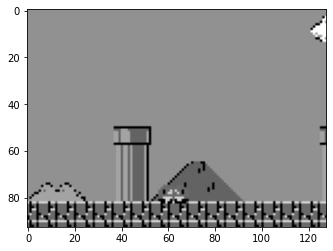

In [140]:
a = image.decode()
b = a.split('json')[1]
c = json.loads(b)
d = c['matriz']
e = np.asarray(d, dtype=np.int16)
plt.imshow(e, cmap='gray')
plt.show()

In [77]:
'''
    Press Joypad
'''
import time
import random
begin = time.time()
images = []
i = 0
while True:
    try:
        print("I: {}".format(i))
        data = server.sendCommandAndReceiveOperation(json.dumps({'operation': 'nextStep',
          'params': {
              'press': chooseAction(random.randint(0,4)),
              'screenshot_params': {
                  'grayscale': True,
                  'down_sample': 2,
                  'len_min_y': 45,
                  'len_max_y': 230
              }
          }
        }))
        i+=1
    except Exception as e:
        print('Except: {}'.format(e))
        break
    
end = time.time()
print(end - begin)
print('I: {}'.format(i))


I: 0
I: 1
I: 2
I: 3
I: 4
I: 5
I: 6
I: 7
I: 8
I: 9
I: 10
I: 11
I: 12
I: 13
I: 14
I: 15
I: 16
I: 17
I: 18
I: 19
I: 20
I: 21
I: 22
I: 23
I: 24
I: 25
I: 26
I: 27
I: 28
I: 29
I: 30
I: 31
I: 32
I: 33
I: 34
I: 35
I: 36
I: 37
I: 38
I: 39
I: 40
I: 41
I: 42
I: 43
I: 44
I: 45
I: 46
I: 47
I: 48
I: 49
I: 50
I: 51
I: 52
I: 53
I: 54
I: 55
I: 56
I: 57
I: 58
I: 59
I: 60
I: 61
I: 62
I: 63
I: 64
I: 65
I: 66
I: 67
I: 68
I: 69
I: 70
I: 71
I: 72
I: 73
I: 74
I: 75
I: 76
I: 77
I: 78
I: 79
I: 80
I: 81
I: 82
I: 83
I: 84
I: 85
I: 86
I: 87
I: 88
I: 89
I: 90
I: 91
I: 92
I: 93
I: 94
I: 95
I: 96
I: 97
I: 98
I: 99
I: 100
I: 101
I: 102
I: 103
I: 104
I: 105
I: 106
I: 107
I: 108
I: 109
I: 110
I: 111
I: 112
I: 113
I: 114
I: 115
I: 116
I: 117
I: 118
I: 119
I: 120
I: 121
I: 122
I: 123
I: 124
I: 125
I: 126
I: 127
I: 128
I: 129
I: 130
I: 131
I: 132
I: 133
I: 134
I: 135
I: 136
I: 137
I: 138
I: 139
I: 140
I: 141
I: 142
I: 143
I: 144
I: 145
I: 146
I: 147
I: 148
I: 149
I: 150
I: 151
I: 152
I: 153
I: 154
I: 155
I: 156
I: 157
I: 1

I: 1167
I: 1168
I: 1169
I: 1170
I: 1171
I: 1172
I: 1173
I: 1174
I: 1175
I: 1176
I: 1177
I: 1178
I: 1179
I: 1180
I: 1181
I: 1182
I: 1183
I: 1184
I: 1185
I: 1186
I: 1187
I: 1188
I: 1189
I: 1190
I: 1191
I: 1192
I: 1193
I: 1194
I: 1195
I: 1196
I: 1197
I: 1198
I: 1199
I: 1200
I: 1201
I: 1202
I: 1203
I: 1204
I: 1205
I: 1206
I: 1207
I: 1208
I: 1209
I: 1210
I: 1211
I: 1212
I: 1213
I: 1214
I: 1215
I: 1216
I: 1217
I: 1218
I: 1219
I: 1220
I: 1221
I: 1222
I: 1223
I: 1224
I: 1225
I: 1226
I: 1227
I: 1228
I: 1229
I: 1230
I: 1231
I: 1232
I: 1233
I: 1234
I: 1235
I: 1236
I: 1237
I: 1238
I: 1239
I: 1240
I: 1241
I: 1242
I: 1243
I: 1244
I: 1245
I: 1246
I: 1247
I: 1248
I: 1249
I: 1250
I: 1251
I: 1252
I: 1253
I: 1254
I: 1255
I: 1256
I: 1257
I: 1258
I: 1259
I: 1260
I: 1261
I: 1262
I: 1263
I: 1264
I: 1265
I: 1266
I: 1267
I: 1268
I: 1269
I: 1270
I: 1271
I: 1272
I: 1273
I: 1274
I: 1275
I: 1276
I: 1277
I: 1278
I: 1279
I: 1280
I: 1281
I: 1282
I: 1283
I: 1284
I: 1285
I: 1286
I: 1287
I: 1288
I: 1289
I: 1290
I: 1291


I: 2200
I: 2201
I: 2202
I: 2203
I: 2204
I: 2205
I: 2206
I: 2207
I: 2208
I: 2209
I: 2210
I: 2211
I: 2212
I: 2213
I: 2214
I: 2215
I: 2216
I: 2217
I: 2218
I: 2219
I: 2220
I: 2221
I: 2222
I: 2223
I: 2224
I: 2225
I: 2226
I: 2227
I: 2228
I: 2229
I: 2230
I: 2231
I: 2232
I: 2233
I: 2234
I: 2235
I: 2236
I: 2237
I: 2238
I: 2239
I: 2240
I: 2241
I: 2242
I: 2243
I: 2244
I: 2245
I: 2246
I: 2247
I: 2248
I: 2249
I: 2250
I: 2251
I: 2252
I: 2253
I: 2254
I: 2255
I: 2256
I: 2257
I: 2258
I: 2259
I: 2260
I: 2261
I: 2262
I: 2263
I: 2264
I: 2265
I: 2266
I: 2267
I: 2268
I: 2269
I: 2270
I: 2271
I: 2272
I: 2273
I: 2274
I: 2275
I: 2276
I: 2277
I: 2278
I: 2279
I: 2280
I: 2281
I: 2282
I: 2283
I: 2284
I: 2285
I: 2286
I: 2287
I: 2288
I: 2289
I: 2290
I: 2291
I: 2292
I: 2293
I: 2294
I: 2295
I: 2296
I: 2297
I: 2298
I: 2299
I: 2300
I: 2301
I: 2302
I: 2303
I: 2304
I: 2305
I: 2306
I: 2307
I: 2308
I: 2309
I: 2310
I: 2311
I: 2312
I: 2313
I: 2314
I: 2315
I: 2316
I: 2317
I: 2318
I: 2319
I: 2320
I: 2321
I: 2322
I: 2323
I: 2324


I: 3226
I: 3227
I: 3228
I: 3229
I: 3230
I: 3231
I: 3232
I: 3233
I: 3234
I: 3235
I: 3236
I: 3237
I: 3238
I: 3239
I: 3240
I: 3241
I: 3242
I: 3243
I: 3244
I: 3245
I: 3246
I: 3247
I: 3248
I: 3249
I: 3250
I: 3251
I: 3252
I: 3253
I: 3254
I: 3255
I: 3256
I: 3257
I: 3258
I: 3259
I: 3260
I: 3261
I: 3262
I: 3263
I: 3264
I: 3265
I: 3266
I: 3267
I: 3268
I: 3269
I: 3270
I: 3271
I: 3272
I: 3273
I: 3274
I: 3275
I: 3276
I: 3277
I: 3278
I: 3279
I: 3280
I: 3281
I: 3282
I: 3283
I: 3284
I: 3285
I: 3286
I: 3287
I: 3288
I: 3289
I: 3290
I: 3291
I: 3292
I: 3293
I: 3294
I: 3295
I: 3296
I: 3297
I: 3298
I: 3299
I: 3300
I: 3301
I: 3302
I: 3303
I: 3304
I: 3305
I: 3306
I: 3307
I: 3308
I: 3309
I: 3310
I: 3311
I: 3312
I: 3313
I: 3314
I: 3315
I: 3316
I: 3317
I: 3318
I: 3319
I: 3320
I: 3321
I: 3322
I: 3323
I: 3324
I: 3325
I: 3326
I: 3327
I: 3328
I: 3329
I: 3330
I: 3331
I: 3332
I: 3333
I: 3334
I: 3335
I: 3336
I: 3337
I: 3338
I: 3339
I: 3340
I: 3341
I: 3342
I: 3343
I: 3344
I: 3345
I: 3346
I: 3347
I: 3348
I: 3349
I: 3350


I: 4254
I: 4255
I: 4256
I: 4257
I: 4258
I: 4259
I: 4260
I: 4261
I: 4262
I: 4263
I: 4264
I: 4265
I: 4266
I: 4267
I: 4268
I: 4269
I: 4270
I: 4271
I: 4272
I: 4273
I: 4274
I: 4275
I: 4276
I: 4277
I: 4278
I: 4279
I: 4280
I: 4281
I: 4282
I: 4283
I: 4284
I: 4285
I: 4286
I: 4287
I: 4288
I: 4289
I: 4290
I: 4291
I: 4292
I: 4293
I: 4294
I: 4295
I: 4296
I: 4297
I: 4298
I: 4299
I: 4300
I: 4301
I: 4302
I: 4303
I: 4304
I: 4305
I: 4306
I: 4307
I: 4308
I: 4309
I: 4310
I: 4311
I: 4312
I: 4313
I: 4314
I: 4315
I: 4316
I: 4317
I: 4318
I: 4319
I: 4320
I: 4321
I: 4322
I: 4323
I: 4324
I: 4325
I: 4326
I: 4327
I: 4328
I: 4329
I: 4330
I: 4331
I: 4332
I: 4333
I: 4334
I: 4335
I: 4336
I: 4337
I: 4338
I: 4339
I: 4340
I: 4341
I: 4342
I: 4343
I: 4344
I: 4345
I: 4346
I: 4347
I: 4348
I: 4349
I: 4350
I: 4351
I: 4352
I: 4353
I: 4354
I: 4355
I: 4356
I: 4357
I: 4358
I: 4359
I: 4360
I: 4361
I: 4362
I: 4363
I: 4364
I: 4365
I: 4366
I: 4367
I: 4368
I: 4369
I: 4370
I: 4371
I: 4372
I: 4373
I: 4374
I: 4375
I: 4376
I: 4377
I: 4378


I: 5282
I: 5283
I: 5284
I: 5285
I: 5286
I: 5287
I: 5288
I: 5289
I: 5290
I: 5291
I: 5292
I: 5293
I: 5294
I: 5295
I: 5296
I: 5297
I: 5298
I: 5299
I: 5300
I: 5301
I: 5302
I: 5303
I: 5304
I: 5305
I: 5306
I: 5307
I: 5308
I: 5309
I: 5310
I: 5311
I: 5312
I: 5313
I: 5314
I: 5315
I: 5316
I: 5317
I: 5318
I: 5319
I: 5320
I: 5321
I: 5322
I: 5323
I: 5324
I: 5325
I: 5326
I: 5327
I: 5328
I: 5329
I: 5330
I: 5331
I: 5332
I: 5333
I: 5334
I: 5335
I: 5336
I: 5337
I: 5338
I: 5339
I: 5340
I: 5341
I: 5342
I: 5343
I: 5344
I: 5345
I: 5346
I: 5347
I: 5348
I: 5349
I: 5350
I: 5351
I: 5352
I: 5353
I: 5354
I: 5355
I: 5356
I: 5357
I: 5358
I: 5359
I: 5360
I: 5361
I: 5362
I: 5363
I: 5364
I: 5365
I: 5366
I: 5367
I: 5368
I: 5369
I: 5370
I: 5371
I: 5372
I: 5373
I: 5374
I: 5375
I: 5376
I: 5377
I: 5378
I: 5379
I: 5380
I: 5381
I: 5382
I: 5383
I: 5384
I: 5385
I: 5386
I: 5387
I: 5388
I: 5389
I: 5390
I: 5391
I: 5392
I: 5393
I: 5394
I: 5395
I: 5396
I: 5397
I: 5398
I: 5399
I: 5400
I: 5401
I: 5402
I: 5403
I: 5404
I: 5405
I: 5406


I: 6309
I: 6310
I: 6311
I: 6312
I: 6313
I: 6314
I: 6315
I: 6316
I: 6317
I: 6318
I: 6319
I: 6320
I: 6321
I: 6322
I: 6323
I: 6324
I: 6325
I: 6326
I: 6327
I: 6328
I: 6329
I: 6330
I: 6331
I: 6332
I: 6333
I: 6334
I: 6335
I: 6336
I: 6337
I: 6338
I: 6339
I: 6340
I: 6341
I: 6342
I: 6343
I: 6344
I: 6345
I: 6346
I: 6347
I: 6348
I: 6349
I: 6350
I: 6351
I: 6352
I: 6353
I: 6354
I: 6355
I: 6356
I: 6357
I: 6358
I: 6359
I: 6360
I: 6361
I: 6362
I: 6363
I: 6364
I: 6365
I: 6366
I: 6367
I: 6368
I: 6369
I: 6370
I: 6371
I: 6372
I: 6373
I: 6374
I: 6375
I: 6376
I: 6377
I: 6378
I: 6379
I: 6380
I: 6381
I: 6382
I: 6383
I: 6384
I: 6385
I: 6386
I: 6387
I: 6388
I: 6389
I: 6390
I: 6391
I: 6392
I: 6393
I: 6394
I: 6395
I: 6396
I: 6397
I: 6398
I: 6399
I: 6400
I: 6401
I: 6402
I: 6403
I: 6404
I: 6405
I: 6406
I: 6407
I: 6408
I: 6409
I: 6410
I: 6411
I: 6412
I: 6413
I: 6414
I: 6415
I: 6416
I: 6417
I: 6418
I: 6419
I: 6420
I: 6421
I: 6422
I: 6423
I: 6424
I: 6425
I: 6426
I: 6427
I: 6428
I: 6429
I: 6430
I: 6431
I: 6432
I: 6433


I: 7334
I: 7335
I: 7336
I: 7337
I: 7338
I: 7339
I: 7340
I: 7341
I: 7342
I: 7343
I: 7344
I: 7345
I: 7346
I: 7347
I: 7348
I: 7349
I: 7350
I: 7351
I: 7352
I: 7353
I: 7354
I: 7355
I: 7356
I: 7357
I: 7358
I: 7359
I: 7360
I: 7361
I: 7362
I: 7363
I: 7364
I: 7365
I: 7366
I: 7367
I: 7368
I: 7369
I: 7370
I: 7371
I: 7372
I: 7373
I: 7374
I: 7375
I: 7376
I: 7377
I: 7378
I: 7379
I: 7380
I: 7381
I: 7382
I: 7383
I: 7384
I: 7385
I: 7386
I: 7387
I: 7388
I: 7389
I: 7390
I: 7391
I: 7392
I: 7393
I: 7394
I: 7395
I: 7396
I: 7397
I: 7398
I: 7399
I: 7400
I: 7401
I: 7402
I: 7403
I: 7404
I: 7405
I: 7406
I: 7407
I: 7408
I: 7409
I: 7410
I: 7411
I: 7412
I: 7413
I: 7414
I: 7415
I: 7416
I: 7417
I: 7418
I: 7419
I: 7420
I: 7421
I: 7422
I: 7423
I: 7424
I: 7425
I: 7426
I: 7427
I: 7428
I: 7429
I: 7430
I: 7431
I: 7432
I: 7433
I: 7434
I: 7435
I: 7436
I: 7437
I: 7438
I: 7439
I: 7440
I: 7441
I: 7442
I: 7443
I: 7444
I: 7445
I: 7446
I: 7447
I: 7448
I: 7449
I: 7450
I: 7451
I: 7452
I: 7453
I: 7454
I: 7455
I: 7456
I: 7457
I: 7458


I: 8360
I: 8361
I: 8362
I: 8363
I: 8364
I: 8365
I: 8366
I: 8367
I: 8368
I: 8369
I: 8370
I: 8371
I: 8372
I: 8373
I: 8374
I: 8375
I: 8376
I: 8377
I: 8378
I: 8379
I: 8380
I: 8381
I: 8382
I: 8383
I: 8384
I: 8385
I: 8386
I: 8387
I: 8388
I: 8389
I: 8390
I: 8391
I: 8392
I: 8393
I: 8394
I: 8395
I: 8396
I: 8397
I: 8398
I: 8399
I: 8400
I: 8401
I: 8402
I: 8403
I: 8404
I: 8405
I: 8406
I: 8407
I: 8408
I: 8409
I: 8410
I: 8411
I: 8412
I: 8413
I: 8414
I: 8415
I: 8416
I: 8417
I: 8418
I: 8419
I: 8420
I: 8421
I: 8422
I: 8423
I: 8424
I: 8425
I: 8426
I: 8427
I: 8428
I: 8429
I: 8430
I: 8431
I: 8432
I: 8433
I: 8434
I: 8435
I: 8436
I: 8437
I: 8438
I: 8439
I: 8440
I: 8441
I: 8442
I: 8443
I: 8444
I: 8445
I: 8446
I: 8447
I: 8448
I: 8449
I: 8450
I: 8451
I: 8452
I: 8453
I: 8454
I: 8455
I: 8456
I: 8457
I: 8458
I: 8459
I: 8460
I: 8461
I: 8462
I: 8463
I: 8464
I: 8465
I: 8466
I: 8467
I: 8468
I: 8469
I: 8470
I: 8471
I: 8472
I: 8473
I: 8474
I: 8475
I: 8476
I: 8477
I: 8478
I: 8479
I: 8480
I: 8481
I: 8482
I: 8483
I: 8484


I: 9389
I: 9390
I: 9391
I: 9392
I: 9393
I: 9394
I: 9395
I: 9396
I: 9397
I: 9398
I: 9399
I: 9400
I: 9401
I: 9402
I: 9403
I: 9404
I: 9405
I: 9406
I: 9407
I: 9408
I: 9409
I: 9410
I: 9411
I: 9412
I: 9413
I: 9414
I: 9415
I: 9416
I: 9417
I: 9418
I: 9419
I: 9420
I: 9421
I: 9422
I: 9423
I: 9424
I: 9425
I: 9426
I: 9427
I: 9428
I: 9429
I: 9430
I: 9431
I: 9432
I: 9433
I: 9434
I: 9435
I: 9436
I: 9437
I: 9438
I: 9439
I: 9440
I: 9441
I: 9442
I: 9443
I: 9444
I: 9445
I: 9446
I: 9447
I: 9448
I: 9449
I: 9450
I: 9451
I: 9452
I: 9453
I: 9454
I: 9455
I: 9456
I: 9457
I: 9458
I: 9459
I: 9460
I: 9461
I: 9462
I: 9463
I: 9464
I: 9465
I: 9466
I: 9467
I: 9468
I: 9469
I: 9470
I: 9471
I: 9472
I: 9473
I: 9474
I: 9475
I: 9476
I: 9477
I: 9478
I: 9479
I: 9480
I: 9481
I: 9482
I: 9483
I: 9484
I: 9485
I: 9486
I: 9487
I: 9488
I: 9489
I: 9490
I: 9491
I: 9492
I: 9493
I: 9494
I: 9495
I: 9496
I: 9497
I: 9498
I: 9499
I: 9500
I: 9501
I: 9502
I: 9503
I: 9504
I: 9505
I: 9506
I: 9507
I: 9508
I: 9509
I: 9510
I: 9511
I: 9512
I: 9513


I: 10369
I: 10370
I: 10371
I: 10372
I: 10373
I: 10374
I: 10375
I: 10376
I: 10377
I: 10378
I: 10379
I: 10380
I: 10381
I: 10382
I: 10383
I: 10384
I: 10385
I: 10386
I: 10387
I: 10388
I: 10389
I: 10390
I: 10391
I: 10392
I: 10393
I: 10394
I: 10395
I: 10396
I: 10397
I: 10398
I: 10399
I: 10400
I: 10401
I: 10402
I: 10403
I: 10404
I: 10405
I: 10406
I: 10407
I: 10408
I: 10409
I: 10410
I: 10411
I: 10412
I: 10413
I: 10414
I: 10415
I: 10416
I: 10417
I: 10418
I: 10419
I: 10420
I: 10421
I: 10422
I: 10423
I: 10424
I: 10425
I: 10426
I: 10427
I: 10428
I: 10429
I: 10430
I: 10431
I: 10432
I: 10433
I: 10434
I: 10435
I: 10436
I: 10437
I: 10438
I: 10439
I: 10440
I: 10441
I: 10442
I: 10443
I: 10444
I: 10445
I: 10446
I: 10447
I: 10448
I: 10449
I: 10450
I: 10451
I: 10452
I: 10453
I: 10454
I: 10455
I: 10456
I: 10457
I: 10458
I: 10459
I: 10460
I: 10461
I: 10462
I: 10463
I: 10464
I: 10465
I: 10466
I: 10467
I: 10468
I: 10469
I: 10470
I: 10471
I: 10472
I: 10473
I: 10474
I: 10475
I: 10476
I: 10477
I: 10478
I: 10479
I

I: 11286
I: 11287
I: 11288
I: 11289
I: 11290
I: 11291
I: 11292
I: 11293
I: 11294
I: 11295
I: 11296
I: 11297
I: 11298
I: 11299
I: 11300
I: 11301
I: 11302
I: 11303
I: 11304
I: 11305
I: 11306
I: 11307
I: 11308
I: 11309
I: 11310
I: 11311
I: 11312
I: 11313
I: 11314
I: 11315
I: 11316
I: 11317
I: 11318
I: 11319
I: 11320
I: 11321
I: 11322
I: 11323
I: 11324
I: 11325
I: 11326
I: 11327
I: 11328
I: 11329
I: 11330
I: 11331
I: 11332
I: 11333
I: 11334
I: 11335
I: 11336
I: 11337
I: 11338
I: 11339
I: 11340
I: 11341
I: 11342
I: 11343
I: 11344
I: 11345
I: 11346
I: 11347
I: 11348
I: 11349
I: 11350
I: 11351
I: 11352
I: 11353
I: 11354
I: 11355
I: 11356
I: 11357
I: 11358
I: 11359
I: 11360
I: 11361
I: 11362
I: 11363
I: 11364
I: 11365
I: 11366
I: 11367
I: 11368
I: 11369
I: 11370
I: 11371
I: 11372
I: 11373
I: 11374
I: 11375
I: 11376
I: 11377
I: 11378
I: 11379
I: 11380
I: 11381
I: 11382
I: 11383
I: 11384
I: 11385
I: 11386
I: 11387
I: 11388
I: 11389
I: 11390
I: 11391
I: 11392
I: 11393
I: 11394
I: 11395
I: 11396
I

I: 12201
I: 12202
I: 12203
I: 12204
I: 12205
I: 12206
I: 12207
I: 12208
I: 12209
I: 12210
I: 12211
I: 12212
I: 12213
I: 12214
I: 12215
I: 12216
I: 12217
I: 12218
I: 12219
I: 12220
I: 12221
I: 12222
I: 12223
I: 12224
I: 12225
I: 12226
I: 12227
I: 12228
I: 12229
I: 12230
I: 12231
I: 12232
I: 12233
I: 12234
I: 12235
I: 12236
I: 12237
I: 12238
I: 12239
I: 12240
I: 12241
I: 12242
I: 12243
I: 12244
I: 12245
I: 12246
I: 12247
I: 12248
I: 12249
I: 12250
I: 12251
I: 12252
I: 12253
I: 12254
I: 12255
I: 12256
I: 12257
I: 12258
I: 12259
I: 12260
I: 12261
I: 12262
I: 12263
I: 12264
I: 12265
I: 12266
I: 12267
I: 12268
I: 12269
I: 12270
I: 12271
I: 12272
I: 12273
I: 12274
I: 12275
I: 12276
I: 12277
I: 12278
I: 12279
I: 12280
I: 12281
I: 12282
I: 12283
I: 12284
I: 12285
I: 12286
I: 12287
I: 12288
I: 12289
I: 12290
I: 12291
I: 12292
I: 12293
I: 12294
I: 12295
I: 12296
I: 12297
I: 12298
I: 12299
I: 12300
I: 12301
I: 12302
I: 12303
I: 12304
I: 12305
I: 12306
I: 12307
I: 12308
I: 12309
I: 12310
I: 12311
I

I: 13115
I: 13116
I: 13117
I: 13118
I: 13119
I: 13120
I: 13121
I: 13122
I: 13123
I: 13124
I: 13125
I: 13126
I: 13127
I: 13128
I: 13129
I: 13130
I: 13131
I: 13132
I: 13133
I: 13134
I: 13135
I: 13136
I: 13137
I: 13138
I: 13139
I: 13140
I: 13141
I: 13142
I: 13143
I: 13144
I: 13145
I: 13146
I: 13147
I: 13148
I: 13149
I: 13150
I: 13151
I: 13152
I: 13153
I: 13154
I: 13155
I: 13156
I: 13157
I: 13158
I: 13159
I: 13160
I: 13161
I: 13162
I: 13163
I: 13164
I: 13165
I: 13166
I: 13167
I: 13168
I: 13169
I: 13170
I: 13171
I: 13172
I: 13173
I: 13174
I: 13175
I: 13176
I: 13177
I: 13178
I: 13179
I: 13180
I: 13181
I: 13182
I: 13183
I: 13184
I: 13185
I: 13186
I: 13187
I: 13188
I: 13189
I: 13190
I: 13191
I: 13192
I: 13193
I: 13194
I: 13195
I: 13196
I: 13197
I: 13198
I: 13199
I: 13200
I: 13201
I: 13202
I: 13203
I: 13204
I: 13205
I: 13206
I: 13207
I: 13208
I: 13209
I: 13210
I: 13211
I: 13212
I: 13213
I: 13214
I: 13215
I: 13216
I: 13217
I: 13218
I: 13219
I: 13220
I: 13221
I: 13222
I: 13223
I: 13224
I: 13225
I

I: 14034
I: 14035
I: 14036
I: 14037
I: 14038
I: 14039
I: 14040
I: 14041
I: 14042
I: 14043
I: 14044
I: 14045
I: 14046
I: 14047
I: 14048
I: 14049
I: 14050
I: 14051
I: 14052
I: 14053
I: 14054
I: 14055
I: 14056
I: 14057
I: 14058
I: 14059
I: 14060
I: 14061
I: 14062
I: 14063
I: 14064
I: 14065
I: 14066
I: 14067
I: 14068
I: 14069
I: 14070
I: 14071
I: 14072
I: 14073
I: 14074
I: 14075
I: 14076
I: 14077
I: 14078
I: 14079
I: 14080
I: 14081
I: 14082
I: 14083
I: 14084
I: 14085
I: 14086
I: 14087
I: 14088
I: 14089
I: 14090
I: 14091
I: 14092
I: 14093
I: 14094
I: 14095
I: 14096
I: 14097
I: 14098
I: 14099
I: 14100
I: 14101
I: 14102
I: 14103
I: 14104
I: 14105
I: 14106
I: 14107
I: 14108
I: 14109
I: 14110
I: 14111
I: 14112
I: 14113
I: 14114
I: 14115
I: 14116
I: 14117
I: 14118
I: 14119
I: 14120
I: 14121
I: 14122
I: 14123
I: 14124
I: 14125
I: 14126
I: 14127
I: 14128
I: 14129
I: 14130
I: 14131
I: 14132
I: 14133
I: 14134
I: 14135
I: 14136
I: 14137
I: 14138
I: 14139
I: 14140
I: 14141
I: 14142
I: 14143
I: 14144
I

I: 14952
I: 14953
I: 14954
I: 14955
I: 14956
I: 14957
I: 14958
I: 14959
I: 14960
I: 14961
I: 14962
I: 14963
I: 14964
I: 14965
I: 14966
I: 14967
I: 14968
I: 14969
I: 14970
I: 14971
I: 14972
I: 14973
I: 14974
I: 14975
I: 14976
I: 14977
I: 14978
I: 14979
I: 14980
I: 14981
I: 14982
I: 14983
I: 14984
I: 14985
I: 14986
I: 14987
I: 14988
I: 14989
I: 14990
I: 14991
I: 14992
I: 14993
I: 14994
I: 14995
I: 14996
I: 14997
I: 14998
I: 14999
I: 15000
I: 15001
I: 15002
I: 15003
I: 15004
I: 15005
I: 15006
I: 15007
I: 15008
I: 15009
I: 15010
I: 15011
I: 15012
I: 15013
I: 15014
I: 15015
I: 15016
I: 15017
I: 15018
I: 15019
I: 15020
I: 15021
I: 15022
I: 15023
I: 15024
I: 15025
I: 15026
I: 15027
I: 15028
I: 15029
I: 15030
I: 15031
I: 15032
I: 15033
I: 15034
I: 15035
I: 15036
I: 15037
I: 15038
I: 15039
I: 15040
I: 15041
I: 15042
I: 15043
I: 15044
I: 15045
I: 15046
I: 15047
I: 15048
I: 15049
I: 15050
I: 15051
I: 15052
I: 15053
I: 15054
I: 15055
I: 15056
I: 15057
I: 15058
I: 15059
I: 15060
I: 15061
I: 15062
I

I: 15867
I: 15868
I: 15869
I: 15870
I: 15871
I: 15872
I: 15873
I: 15874
I: 15875
I: 15876
I: 15877
I: 15878
I: 15879
I: 15880
I: 15881
I: 15882
I: 15883
I: 15884
I: 15885
I: 15886
I: 15887
I: 15888
I: 15889
I: 15890
I: 15891
I: 15892
I: 15893
I: 15894
I: 15895
I: 15896
I: 15897
I: 15898
I: 15899
I: 15900
I: 15901
I: 15902
I: 15903
I: 15904
I: 15905
I: 15906
I: 15907
I: 15908
I: 15909
I: 15910
I: 15911
I: 15912
I: 15913
I: 15914
I: 15915
I: 15916
I: 15917
I: 15918
I: 15919
I: 15920
I: 15921
I: 15922
I: 15923
I: 15924
I: 15925
I: 15926
I: 15927
I: 15928
I: 15929
I: 15930
I: 15931
I: 15932
I: 15933
I: 15934
I: 15935
I: 15936
I: 15937
I: 15938
I: 15939
I: 15940
I: 15941
I: 15942
I: 15943
I: 15944
I: 15945
I: 15946
I: 15947
I: 15948
I: 15949
I: 15950
I: 15951
I: 15952
I: 15953
I: 15954
I: 15955
I: 15956
I: 15957
I: 15958
I: 15959
I: 15960
I: 15961
I: 15962
I: 15963
I: 15964
I: 15965
I: 15966
I: 15967
I: 15968
I: 15969
I: 15970
I: 15971
I: 15972
I: 15973
I: 15974
I: 15975
I: 15976
I: 15977
I

I: 16782
I: 16783
I: 16784
I: 16785
I: 16786
I: 16787
I: 16788
I: 16789
I: 16790
I: 16791
I: 16792
I: 16793
I: 16794
I: 16795
I: 16796
I: 16797
I: 16798
I: 16799
I: 16800
I: 16801
I: 16802
I: 16803
I: 16804
I: 16805
I: 16806
I: 16807
I: 16808
I: 16809
I: 16810
I: 16811
I: 16812
I: 16813
I: 16814
I: 16815
I: 16816
I: 16817
I: 16818
I: 16819
I: 16820
I: 16821
I: 16822
I: 16823
I: 16824
I: 16825
I: 16826
I: 16827
I: 16828
I: 16829
I: 16830
I: 16831
I: 16832
I: 16833
I: 16834
I: 16835
I: 16836
I: 16837
I: 16838
I: 16839
I: 16840
I: 16841
I: 16842
I: 16843
I: 16844
I: 16845
I: 16846
I: 16847
I: 16848
I: 16849
I: 16850
I: 16851
I: 16852
I: 16853
I: 16854
I: 16855
I: 16856
I: 16857
I: 16858
I: 16859
I: 16860
I: 16861
I: 16862
I: 16863
I: 16864
I: 16865
I: 16866
I: 16867
I: 16868
I: 16869
I: 16870
I: 16871
I: 16872
I: 16873
I: 16874
I: 16875
I: 16876
I: 16877
I: 16878
I: 16879
I: 16880
I: 16881
I: 16882
I: 16883
I: 16884
I: 16885
I: 16886
I: 16887
I: 16888
I: 16889
I: 16890
I: 16891
I: 16892
I

I: 17701
I: 17702
I: 17703
I: 17704
I: 17705
I: 17706
I: 17707
I: 17708
I: 17709
I: 17710
I: 17711
I: 17712
I: 17713
I: 17714
I: 17715
I: 17716
I: 17717
I: 17718
I: 17719
I: 17720
I: 17721
I: 17722
I: 17723
I: 17724
I: 17725
I: 17726
I: 17727
I: 17728
I: 17729
I: 17730
I: 17731
I: 17732
I: 17733
I: 17734
I: 17735
I: 17736
I: 17737
I: 17738
I: 17739
I: 17740
I: 17741
I: 17742
I: 17743
I: 17744
I: 17745
I: 17746
I: 17747
I: 17748
I: 17749
I: 17750
I: 17751
I: 17752
I: 17753
I: 17754
I: 17755
I: 17756
I: 17757
I: 17758
I: 17759
I: 17760
I: 17761
I: 17762
I: 17763
I: 17764
I: 17765
I: 17766
I: 17767
I: 17768
I: 17769
I: 17770
I: 17771
I: 17772
I: 17773
I: 17774
I: 17775
I: 17776
I: 17777
I: 17778
I: 17779
I: 17780
I: 17781
I: 17782
I: 17783
I: 17784
I: 17785
I: 17786
I: 17787
I: 17788
I: 17789
I: 17790
I: 17791
I: 17792
I: 17793
I: 17794
I: 17795
I: 17796
I: 17797
I: 17798
I: 17799
I: 17800
I: 17801
I: 17802
I: 17803
I: 17804
I: 17805
I: 17806
I: 17807
I: 17808
I: 17809
I: 17810
I: 17811
I

I: 18612
I: 18613
I: 18614
I: 18615
I: 18616
I: 18617
I: 18618
I: 18619
I: 18620
I: 18621
I: 18622
I: 18623
I: 18624
I: 18625
I: 18626
I: 18627
I: 18628
I: 18629
I: 18630
I: 18631
I: 18632
I: 18633
I: 18634
I: 18635
I: 18636
I: 18637
I: 18638
I: 18639
I: 18640
I: 18641
I: 18642
I: 18643
I: 18644
I: 18645
I: 18646
I: 18647
I: 18648
I: 18649
I: 18650
I: 18651
I: 18652
I: 18653
I: 18654
I: 18655
I: 18656
I: 18657
I: 18658
I: 18659
I: 18660
I: 18661
I: 18662
I: 18663
I: 18664
I: 18665
I: 18666
I: 18667
I: 18668
I: 18669
I: 18670
I: 18671
I: 18672
I: 18673
I: 18674
I: 18675
I: 18676
I: 18677
I: 18678
I: 18679
I: 18680
I: 18681
I: 18682
I: 18683
I: 18684
I: 18685
I: 18686
I: 18687
I: 18688
I: 18689
I: 18690
I: 18691
I: 18692
I: 18693
I: 18694
I: 18695
I: 18696
I: 18697
I: 18698
I: 18699
I: 18700
I: 18701
I: 18702
I: 18703
I: 18704
I: 18705
I: 18706
I: 18707
I: 18708
I: 18709
I: 18710
I: 18711
I: 18712
I: 18713
I: 18714
I: 18715
I: 18716
I: 18717
I: 18718
I: 18719
I: 18720
I: 18721
I: 18722
I

I: 19525
I: 19526
I: 19527
I: 19528
I: 19529
I: 19530
I: 19531
I: 19532
I: 19533
I: 19534
I: 19535
I: 19536
I: 19537
I: 19538
I: 19539
I: 19540
I: 19541
I: 19542
I: 19543
I: 19544
I: 19545
I: 19546
I: 19547
I: 19548
I: 19549
I: 19550
I: 19551
I: 19552
I: 19553
I: 19554
I: 19555
I: 19556
I: 19557
I: 19558
I: 19559
I: 19560
I: 19561
I: 19562
I: 19563
I: 19564
I: 19565
I: 19566
I: 19567
I: 19568
I: 19569
I: 19570
I: 19571
I: 19572
I: 19573
I: 19574
I: 19575
I: 19576
I: 19577
I: 19578
I: 19579
I: 19580
I: 19581
I: 19582
I: 19583
I: 19584
I: 19585
I: 19586
I: 19587
I: 19588
I: 19589
I: 19590
I: 19591
I: 19592
I: 19593
I: 19594
I: 19595
I: 19596
I: 19597
I: 19598
I: 19599
I: 19600
I: 19601
I: 19602
I: 19603
I: 19604
I: 19605
I: 19606
I: 19607
I: 19608
I: 19609
I: 19610
I: 19611
I: 19612
I: 19613
I: 19614
I: 19615
I: 19616
I: 19617
I: 19618
I: 19619
I: 19620
I: 19621
I: 19622
I: 19623
I: 19624
I: 19625
I: 19626
I: 19627
I: 19628
I: 19629
I: 19630
I: 19631
I: 19632
I: 19633
I: 19634
I: 19635
I

I: 20439
I: 20440
I: 20441
I: 20442
I: 20443
I: 20444
I: 20445
I: 20446
I: 20447
I: 20448
I: 20449
I: 20450
I: 20451
I: 20452
I: 20453
I: 20454
I: 20455
I: 20456
I: 20457
I: 20458
I: 20459
I: 20460
I: 20461
I: 20462
I: 20463
I: 20464
I: 20465
I: 20466
I: 20467
I: 20468
I: 20469
I: 20470
I: 20471
I: 20472
I: 20473
I: 20474
I: 20475
I: 20476
I: 20477
I: 20478
I: 20479
I: 20480
I: 20481
I: 20482
I: 20483
I: 20484
I: 20485
I: 20486
I: 20487
I: 20488
I: 20489
I: 20490
I: 20491
I: 20492
I: 20493
I: 20494
I: 20495
I: 20496
I: 20497
I: 20498
I: 20499
I: 20500
I: 20501
I: 20502
I: 20503
I: 20504
I: 20505
I: 20506
I: 20507
I: 20508
I: 20509
I: 20510
I: 20511
I: 20512
I: 20513
I: 20514
I: 20515
I: 20516
I: 20517
I: 20518
I: 20519
I: 20520
I: 20521
I: 20522
I: 20523
I: 20524
I: 20525
I: 20526
I: 20527
I: 20528
I: 20529
I: 20530
I: 20531
I: 20532
I: 20533
I: 20534
I: 20535
I: 20536
I: 20537
I: 20538
I: 20539
I: 20540
I: 20541
I: 20542
I: 20543
I: 20544
I: 20545
I: 20546
I: 20547
I: 20548
I: 20549
I

I: 21352
I: 21353
I: 21354
I: 21355
I: 21356
I: 21357
I: 21358
I: 21359
I: 21360
I: 21361
I: 21362
I: 21363
I: 21364
I: 21365
I: 21366
I: 21367
I: 21368
I: 21369
I: 21370
I: 21371
I: 21372
I: 21373
I: 21374
I: 21375
I: 21376
I: 21377
I: 21378
I: 21379
I: 21380
I: 21381
I: 21382
I: 21383
I: 21384
I: 21385
I: 21386
I: 21387
I: 21388
I: 21389
I: 21390
I: 21391
I: 21392
I: 21393
I: 21394
I: 21395
I: 21396
I: 21397
I: 21398
I: 21399
I: 21400
I: 21401
I: 21402
I: 21403
I: 21404
I: 21405
I: 21406
I: 21407
I: 21408
I: 21409
I: 21410
I: 21411
I: 21412
I: 21413
I: 21414
I: 21415
I: 21416
I: 21417
I: 21418
I: 21419
I: 21420
I: 21421
I: 21422
I: 21423
I: 21424
I: 21425
I: 21426
I: 21427
I: 21428
I: 21429
I: 21430
I: 21431
I: 21432
I: 21433
I: 21434
I: 21435
I: 21436
I: 21437
I: 21438
I: 21439
I: 21440
I: 21441
I: 21442
I: 21443
I: 21444
I: 21445
I: 21446
I: 21447
I: 21448
I: 21449
I: 21450
I: 21451
I: 21452
I: 21453
I: 21454
I: 21455
I: 21456
I: 21457
I: 21458
I: 21459
I: 21460
I: 21461
I: 21462
I

I: 22270
I: 22271
I: 22272
I: 22273
I: 22274
I: 22275
I: 22276
I: 22277
I: 22278
I: 22279
I: 22280
I: 22281
I: 22282
I: 22283
I: 22284
I: 22285
I: 22286
I: 22287
I: 22288
I: 22289
I: 22290
I: 22291
I: 22292
I: 22293
I: 22294
I: 22295
I: 22296
I: 22297
I: 22298
I: 22299
I: 22300
I: 22301
I: 22302
I: 22303
I: 22304
I: 22305
I: 22306
I: 22307
I: 22308
I: 22309
I: 22310
I: 22311
I: 22312
I: 22313
I: 22314
I: 22315
I: 22316
I: 22317
I: 22318
I: 22319
I: 22320
I: 22321
I: 22322
I: 22323
I: 22324
I: 22325
I: 22326
I: 22327
I: 22328
I: 22329
I: 22330
I: 22331
I: 22332
I: 22333
I: 22334
I: 22335
I: 22336
I: 22337
I: 22338
I: 22339
I: 22340
I: 22341
I: 22342
I: 22343
I: 22344
I: 22345
I: 22346
I: 22347
I: 22348
I: 22349
I: 22350
I: 22351
I: 22352
I: 22353
I: 22354
I: 22355
I: 22356
I: 22357
I: 22358
I: 22359
I: 22360
I: 22361
I: 22362
I: 22363
I: 22364
I: 22365
I: 22366
I: 22367
I: 22368
I: 22369
I: 22370
I: 22371
I: 22372
I: 22373
I: 22374
I: 22375
I: 22376
I: 22377
I: 22378
I: 22379
I: 22380
I

I: 23187
I: 23188
I: 23189
I: 23190
I: 23191
I: 23192
I: 23193
I: 23194
I: 23195
I: 23196
I: 23197
I: 23198
I: 23199
I: 23200
I: 23201
I: 23202
I: 23203
I: 23204
I: 23205
I: 23206
I: 23207
I: 23208
I: 23209
I: 23210
I: 23211
I: 23212
I: 23213
I: 23214
I: 23215
I: 23216
I: 23217
I: 23218
I: 23219
I: 23220
I: 23221
I: 23222
I: 23223
I: 23224
I: 23225
I: 23226
I: 23227
I: 23228
I: 23229
I: 23230
I: 23231
I: 23232
I: 23233
I: 23234
I: 23235
I: 23236
I: 23237
I: 23238
I: 23239
I: 23240
I: 23241
I: 23242
I: 23243
I: 23244
I: 23245
I: 23246
I: 23247
I: 23248
I: 23249
I: 23250
I: 23251
I: 23252
I: 23253
I: 23254
I: 23255
I: 23256
I: 23257
I: 23258
I: 23259
I: 23260
I: 23261
I: 23262
I: 23263
I: 23264
I: 23265
I: 23266
I: 23267
I: 23268
I: 23269
I: 23270
I: 23271
I: 23272
I: 23273
I: 23274
I: 23275
I: 23276
I: 23277
I: 23278
I: 23279
I: 23280
I: 23281
I: 23282
I: 23283
I: 23284
I: 23285
I: 23286
I: 23287
I: 23288
I: 23289
I: 23290
I: 23291
I: 23292
I: 23293
I: 23294
I: 23295
I: 23296
I: 23297
I

I: 24098
I: 24099
I: 24100
I: 24101
I: 24102
I: 24103
I: 24104
I: 24105
I: 24106
I: 24107
I: 24108
I: 24109
I: 24110
I: 24111
I: 24112
I: 24113
I: 24114
I: 24115
I: 24116
I: 24117
I: 24118
I: 24119
I: 24120
I: 24121
I: 24122
I: 24123
I: 24124
I: 24125
I: 24126
I: 24127
I: 24128
I: 24129
I: 24130
I: 24131
I: 24132
I: 24133
I: 24134
I: 24135
I: 24136
I: 24137
I: 24138
I: 24139
I: 24140
I: 24141
I: 24142
I: 24143
I: 24144
I: 24145
I: 24146
I: 24147
I: 24148
I: 24149
I: 24150
I: 24151
I: 24152
I: 24153
I: 24154
I: 24155
I: 24156
I: 24157
I: 24158
I: 24159
I: 24160
I: 24161
I: 24162
I: 24163
I: 24164
I: 24165
I: 24166
I: 24167
I: 24168
I: 24169
I: 24170
I: 24171
I: 24172
I: 24173
I: 24174
I: 24175
I: 24176
I: 24177
I: 24178
I: 24179
I: 24180
I: 24181
I: 24182
I: 24183
I: 24184
I: 24185
I: 24186
I: 24187
I: 24188
I: 24189
I: 24190
I: 24191
I: 24192
I: 24193
I: 24194
I: 24195
I: 24196
I: 24197
I: 24198
I: 24199
I: 24200
I: 24201
I: 24202
I: 24203
I: 24204
I: 24205
I: 24206
I: 24207
I: 24208
I

I: 25013
I: 25014
I: 25015
I: 25016
I: 25017
I: 25018
I: 25019
I: 25020
I: 25021
I: 25022
I: 25023
I: 25024
I: 25025
I: 25026
I: 25027
I: 25028
I: 25029
I: 25030
I: 25031
I: 25032
I: 25033
I: 25034
I: 25035
I: 25036
I: 25037
I: 25038
I: 25039
I: 25040
I: 25041
I: 25042
I: 25043
I: 25044
I: 25045
I: 25046
I: 25047
I: 25048
I: 25049
I: 25050
I: 25051
I: 25052
I: 25053
I: 25054
I: 25055
I: 25056
I: 25057
I: 25058
I: 25059
I: 25060
I: 25061
I: 25062
I: 25063
I: 25064
I: 25065
I: 25066
I: 25067
I: 25068
I: 25069
I: 25070
I: 25071
I: 25072
I: 25073
I: 25074
I: 25075
I: 25076
I: 25077
I: 25078
I: 25079
I: 25080
I: 25081
I: 25082
I: 25083
I: 25084
I: 25085
I: 25086
I: 25087
I: 25088
I: 25089
I: 25090
I: 25091
I: 25092
I: 25093
I: 25094
I: 25095
I: 25096
I: 25097
I: 25098
I: 25099
I: 25100
I: 25101
I: 25102
I: 25103
I: 25104
I: 25105
I: 25106
I: 25107
I: 25108
I: 25109
I: 25110
I: 25111
I: 25112
I: 25113
I: 25114
I: 25115
I: 25116
I: 25117
I: 25118
I: 25119
I: 25120
I: 25121
I: 25122
I: 25123
I

I: 25929
I: 25930
I: 25931
I: 25932
I: 25933
I: 25934
I: 25935
I: 25936
I: 25937
I: 25938
I: 25939
I: 25940
I: 25941
I: 25942
I: 25943
I: 25944
I: 25945
I: 25946
I: 25947
I: 25948
I: 25949
I: 25950
I: 25951
I: 25952
I: 25953
I: 25954
I: 25955
I: 25956
I: 25957
I: 25958
I: 25959
I: 25960
I: 25961
I: 25962
I: 25963
I: 25964
I: 25965
I: 25966
I: 25967
I: 25968
I: 25969
I: 25970
I: 25971
I: 25972
I: 25973
I: 25974
I: 25975
I: 25976
I: 25977
I: 25978
I: 25979
I: 25980
I: 25981
I: 25982
I: 25983
I: 25984
I: 25985
I: 25986
I: 25987
I: 25988
I: 25989
I: 25990
I: 25991
I: 25992
I: 25993
I: 25994
I: 25995
I: 25996
I: 25997
I: 25998
I: 25999
I: 26000
I: 26001
I: 26002
I: 26003
I: 26004
I: 26005
I: 26006
I: 26007
I: 26008
I: 26009
I: 26010
I: 26011
I: 26012
I: 26013
I: 26014
I: 26015
I: 26016
I: 26017
I: 26018
I: 26019
I: 26020
I: 26021
I: 26022
I: 26023
I: 26024
I: 26025
I: 26026
I: 26027
I: 26028
I: 26029
I: 26030
I: 26031
I: 26032
I: 26033
I: 26034
I: 26035
I: 26036
I: 26037
I: 26038
I: 26039
I

I: 26841
I: 26842
I: 26843
I: 26844
I: 26845
I: 26846
I: 26847
I: 26848
I: 26849
I: 26850
I: 26851
I: 26852
I: 26853
I: 26854
I: 26855
I: 26856
I: 26857
I: 26858
I: 26859
I: 26860
I: 26861
I: 26862
I: 26863
I: 26864
I: 26865
I: 26866
I: 26867
I: 26868
I: 26869
I: 26870
I: 26871
I: 26872
I: 26873
I: 26874
I: 26875
I: 26876
I: 26877
I: 26878
I: 26879
I: 26880
I: 26881
I: 26882
I: 26883
I: 26884
I: 26885
I: 26886
I: 26887
I: 26888
I: 26889
I: 26890
I: 26891
I: 26892
I: 26893
I: 26894
I: 26895
I: 26896
I: 26897
I: 26898
I: 26899
I: 26900
I: 26901
I: 26902
I: 26903
I: 26904
I: 26905
I: 26906
I: 26907
I: 26908
I: 26909
I: 26910
I: 26911
I: 26912
I: 26913
I: 26914
I: 26915
I: 26916
I: 26917
I: 26918
I: 26919
I: 26920
I: 26921
I: 26922
I: 26923
I: 26924
I: 26925
I: 26926
I: 26927
I: 26928
I: 26929
I: 26930
I: 26931
I: 26932
I: 26933
I: 26934
I: 26935
I: 26936
I: 26937
I: 26938
I: 26939
I: 26940
I: 26941
I: 26942
I: 26943
I: 26944
I: 26945
I: 26946
I: 26947
I: 26948
I: 26949
I: 26950
I: 26951
I

I: 27760
I: 27761
I: 27762
I: 27763
I: 27764
I: 27765
I: 27766
I: 27767
I: 27768
I: 27769
I: 27770
I: 27771
I: 27772
I: 27773
I: 27774
I: 27775
I: 27776
I: 27777
I: 27778
I: 27779
I: 27780
I: 27781
I: 27782
I: 27783
I: 27784
I: 27785
I: 27786
I: 27787
I: 27788
I: 27789
I: 27790
I: 27791
I: 27792
I: 27793
I: 27794
I: 27795
I: 27796
I: 27797
I: 27798
I: 27799
I: 27800
I: 27801
I: 27802
I: 27803
I: 27804
I: 27805
I: 27806
I: 27807
I: 27808
I: 27809
I: 27810
I: 27811
I: 27812
I: 27813
I: 27814
I: 27815
I: 27816
I: 27817
I: 27818
I: 27819
I: 27820
I: 27821
I: 27822
I: 27823
I: 27824
I: 27825
I: 27826
I: 27827
I: 27828
I: 27829
I: 27830
I: 27831
I: 27832
I: 27833
I: 27834
I: 27835
I: 27836
I: 27837
I: 27838
I: 27839
I: 27840
I: 27841
I: 27842
I: 27843
I: 27844
I: 27845
I: 27846
I: 27847
I: 27848
I: 27849
I: 27850
I: 27851
I: 27852
I: 27853
I: 27854
I: 27855
I: 27856
I: 27857
I: 27858
I: 27859
I: 27860
I: 27861
I: 27862
I: 27863
I: 27864
I: 27865
I: 27866
I: 27867
I: 27868
I: 27869
I: 27870
I

I: 28676
I: 28677
I: 28678
I: 28679
I: 28680
I: 28681
I: 28682
I: 28683
I: 28684
I: 28685
I: 28686
I: 28687
I: 28688
I: 28689
I: 28690
I: 28691
I: 28692
I: 28693
I: 28694
I: 28695
I: 28696
I: 28697
I: 28698
I: 28699
I: 28700
I: 28701
I: 28702
I: 28703
I: 28704
I: 28705
I: 28706
I: 28707
I: 28708
I: 28709
I: 28710
I: 28711
I: 28712
I: 28713
I: 28714
I: 28715
I: 28716
I: 28717
I: 28718
I: 28719
I: 28720
I: 28721
I: 28722
I: 28723
I: 28724
I: 28725
I: 28726
I: 28727
I: 28728
I: 28729
I: 28730
I: 28731
I: 28732
I: 28733
I: 28734
I: 28735
I: 28736
I: 28737
I: 28738
I: 28739
I: 28740
I: 28741
I: 28742
I: 28743
I: 28744
I: 28745
I: 28746
I: 28747
I: 28748
I: 28749
I: 28750
I: 28751
I: 28752
I: 28753
I: 28754
I: 28755
I: 28756
I: 28757
I: 28758
I: 28759
I: 28760
I: 28761
I: 28762
I: 28763
I: 28764
I: 28765
I: 28766
I: 28767
I: 28768
I: 28769
I: 28770
I: 28771
I: 28772
I: 28773
I: 28774
I: 28775
I: 28776
I: 28777
I: 28778
I: 28779
I: 28780
I: 28781
I: 28782
I: 28783
I: 28784
I: 28785
I: 28786
I

In [11]:
data = server.sendCommandAndReceiveOperation(json.dumps({'operation': 'nextStep',
          'params': {
              'press': 'A',
              'screenshot_params': {
                  'grayscale': True,
                  'down_sample': 2,
                  'len_min_y': 45,
                  'len_max_y': 230
              }
          }
        }))
print(data)

ConnectionResetError: [WinError 10054] Foi forçado o cancelamento de uma conexão existente pelo host remoto

In [5]:
def chooseAction(number):
    return ['down', 'left', 'right', 'A', 'B'][number]

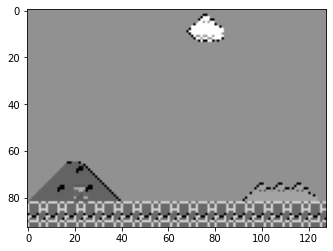

In [60]:
js = jsonsMode(data)
d = js['matriz']
e = np.asarray(d, dtype=np.int16)
plt.imshow(e, cmap='gray')

2

In [123]:
var = '{"matriz": [[1,2,3],[1,2,3]]}'
var02 = json.loads(var)
var02

{'matriz': [[1, 2, 3], [1, 2, 3]]}